# Student Retention - Statistics

Author: Garrett Young (sgyoung@us.ibm.com)
Open Source and Cloud Solutions, IBM Analytics, Public Sector

Before diving into advanced modeling, we are going to test some hypotheses with basic statistics. This notebook gives some examples of how this could be done.

The data was provided by the University of Texas in Austin, Texas in a CSV format. We will import it below, the code is generated automatically for the import by DSX once clicked.

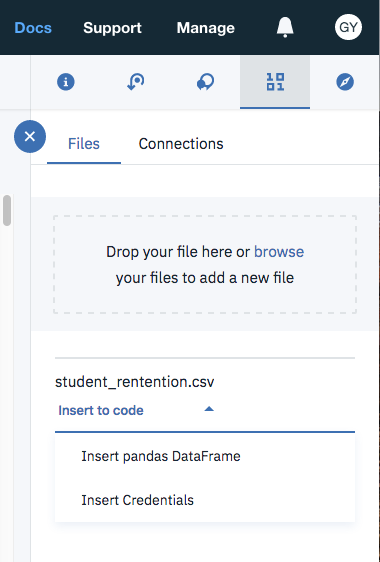

In [4]:
# The code was removed by DSX for sharing.

,Gender,College,In or Out of State,Citizenship,Marital Status,Type of High School,Applied Financial Aid,Received Financial Aid,Other Scholarships,Tuition Rate,...,Student Health,Total Class Hours,Overall GPA,Change in GPA,Housing,Club Memberships,Infirmary Visits,City,State,Retention
0,Female,Liberal Arts & Sciences,Out of State,Yes,Single,Private,Yes,Yes,No,1975,...,Good,26,3.615000,Negative,On Campus,2,0,"Huntsville, AL",Alabama,Retained
1,Male,Health Sciences,Out of State,Yes,Single,Public,Yes,No,No,1975,...,Good,31,2.807742,Positive,On Campus,3,0,"Birmingham, AL",Alabama,Retained


## Come up with a hypothesis

Now that we have imported the data, what column do we think is a factor for student retention? At this point, there isn't any right answer. Our theory is that GPA is one of the major factors, and we will use statistics to see if this is the case. If this proves true, it's a simple model that bases retention on GPA. i.e. a bad GPA will likely result in the student dropping out, while a good GPA means they stay.


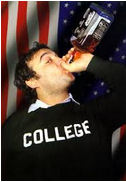

<center>Probably has a good GPA?</center>

### 1. Data Analysis : Frequency Table

Let's start by summarizing the data into a frequency table that consists of:
1. Frequency : How many belong in a certain group
2. Relative Frequency : How often this comes up (Frequency/Total number of rows)

i.e. Since we have data with frequencies, you can use this to group them together and get a count on each frequency.

We are just getting a "feel" for the data here.

#### Setup the Function and  Data

1. We will create a python function that is callable to save time.
2. We are adding a column to the data called "counts". This allows us to sum up each grouping.
3. Get the total for the Relative Frequency

In [5]:
def frequencyTable(data, columnName, groupingMin, groupingMax, groupingInterval):
    import numpy as np
    #Add a column called "counts" with the value of 1 in each row. This is used when we count the data in groups.
    data['counts'] = 1
    #Get the total number of rows
    total = data['counts'].count()
    #Group by Overall GPA and count it based on the "counts" column
    df_data_1_sample_counts = data.groupby(pd.cut(data[columnName], np.arange(groupingMin, groupingMax, groupingInterval))).count()['counts']
    df_data_1_sample_counts = df_data_1_sample_counts.reset_index()
    df_data_1_sample_counts.columns = ['Interval', 'Frequency']
    df_data_1_sample_counts['Relative Frequency'] = df_data_1_sample_counts.Frequency / total
    return df_data_1_sample_counts
    
def frequencyTableGroupBy(data, columnName, groupedColumnName, groupingMin, groupingMax, groupingInterval):
    import numpy as np
    #Add a column called "counts" with the value of 1 in each row. This is used when we count the data in groups.
    data['counts'] = 1
    #Get the total number of rows
    total = data['counts'].count()
    #Group by Overall GPA and count it based on the "counts" column
    df_data_1_sample_counts = data.groupby([groupedColumnName, pd.cut(data[columnName], np.arange(groupingMin, groupingMax, groupingInterval))]).count()['counts']
    df_data_1_sample_counts = df_data_1_sample_counts.reset_index()
    df_data_1_sample_counts.columns = [groupedColumnName, 'Interval', 'Frequency']
    df_data_1_sample_counts['Relative Frequency'] = df_data_1_sample_counts.Frequency / total
    return df_data_1_sample_counts

In this example, we grouped the students GPA by 0.5. This is done with:

np.arange() (see frequencyTable function above), which is used to group things together. The arguements are: np.arange(Starting value to group, ending value to group, interval). In our case, no student had a GPA below 2.0 (clearly not CS majors!), so we started with 2.0. We put in 4.1 to include the 4.0 GPA in our grouping.

In [6]:
frequencyTable = frequencyTable(df_data_1_sample, "Overall GPA", 2.0, 4.1, 0.5)
frequencyTable

,Interval,Frequency,Relative Frequency
0,"(2.0, 2.5]",16,0.002579
1,"(2.5, 3.0]",2060,0.332097
2,"(3.0, 3.5]",3871,0.624053
3,"(3.5, 4.0]",256,0.041270


You can see from the table above, that most GPA's are 3.0 - 3.5 in the data. For extra credit, let's visualize it.

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


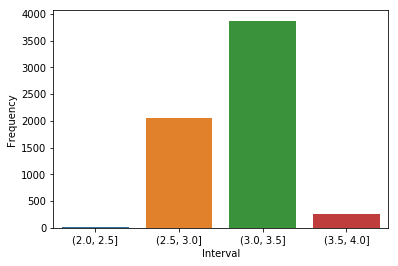

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

sns.barplot(x='Interval',y='Frequency',data=frequencyTable)

Now that we have a basic idea of the groupings of data, let's split it up between the students retained vs not retained and see those same counts.


In [10]:
frequencyTableGroupBy(df_data_1_sample, "Overall GPA", "Retention", 2.0, 4.1, 0.5)

,Retention,Interval,Frequency,Relative Frequency
0,Not retained,"(2.0, 2.5]",10,0.001612
1,Not retained,"(2.5, 3.0]",455,0.073352
2,Not retained,"(3.0, 3.5]",504,0.081251
3,Not retained,"(3.5, 4.0]",22,0.003547
4,Retained,"(2.0, 2.5]",6,0.000967
5,Retained,"(2.5, 3.0]",1605,0.258746
6,Retained,"(3.0, 3.5]",3367,0.542802
7,Retained,"(3.5, 4.0]",234,0.037724


Conclusion : We can see from the counts that there are many more retained students in the data, and split between retained/not retained, 3.0-3.5 GPA still is the highest freqency between both. i.e. They follow the same pattern. We will need to do some more analysis to see if there is any differences between the two groups.

### 2. Data Analysis: Interquartile Range

1. Put the data in numerical order
2. Divide the data into two groups (low and high) at the median
3. Find the median of the low group, this is Q1.
4. Find the median of the high group, this is Q3.

In [18]:
def quantile(x, p):
    # quantile, which represents the value less than which a certain percentile of the data lies. 
    # (The median represents the value less than which 50% of the data lies.)
    """returns the pth-percentile value in x"""
    p_index = int(p * len(x))
    return x)[p_index]

def interquartile_range(x):
    #Both the range and the standard deviation have the same outlier problem that we saw earlier for the mean.
    return quantile(x, 0.75) - quantile(x, 0.25)

In [19]:
df_retained = df_data_1_sample[df_data_1_sample['Retention']=='Retained']
df_not_retained = df_data_1_sample[df_data_1_sample['Retention']=='Not retained']

In this case, the quantile function determines what GPA or lower falls within the percentage of data. For example:

quantile(df_data_1_sample['Overall GPA'], 0.20) 

Gives us a GPA number that is the highest number for the bottom 20% of students. All other GPA's will be lower than the returned result for the lower 20%.

In [39]:
quantile(df_data_1_sample['Overall GPA'], 0.20)

2.907037037

In [40]:
print ("IQR For Everyone:")
print (interquartile_range(df_data_1_sample['Overall GPA']))

print ("\nIQR For Not Retained:")
print (interquartile_range(df_not_retained['Overall GPA']))

print ("\nIQR For Retained:")
print (interquartile_range(df_retained['Overall GPA']))

IQR For Everyone:
0.3089999999999997

IQR For Not Retained:
0.3507692310000001

IQR For Retained:
0.29807692300000044


The above found the difference between the GPA's for 75% of the data and 25% of the data. Basically it means there is a .3 GPA difference between the quantiles. Since this is GPA, a .3 is not very significant. You can also see that it's about the same for retained vs not retained.

The IQR's for both are about the same. We will see the medians are also about the same.

In [41]:
import matplotlib.pyplot as plt

Let's visualize using box/whiskers plotting. You can see:
1. The medians are only 0.1 difference
2. The Q3 and Q1 do not seem to have a large difference between retained and not retained (about .1)
3. The farthest none outlier on the higher end GPA's are about the same, the most significant difference is on the lower (about .2)

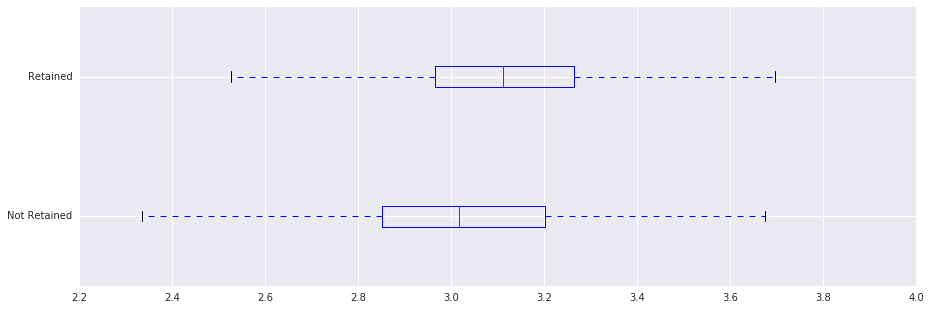

In [12]:
df_boxAndWhiskers = pd.concat([df_not_retained['Overall GPA'], df_retained['Overall GPA']], axis=1, keys=['Not Retained', 'Retained'])
df_boxAndWhiskers.plot.box(vert=False, figsize=(15,5))

Conclusion: There isn't much difference between retained and not retained as far as median and data distribution. We will have to keep looking.

### 3. Data Analysis : Standard Deviation

We will take an more in depth look at the data. First, let's see if the GPA data is symetrical:

In [13]:
# Split up the data

df_GPA_Not_Retained = df_not_retained['Overall GPA']
df_GPA_Retained = df_retained['Overall GPA']
df_GPA_All = df_data_1_sample['Overall GPA']

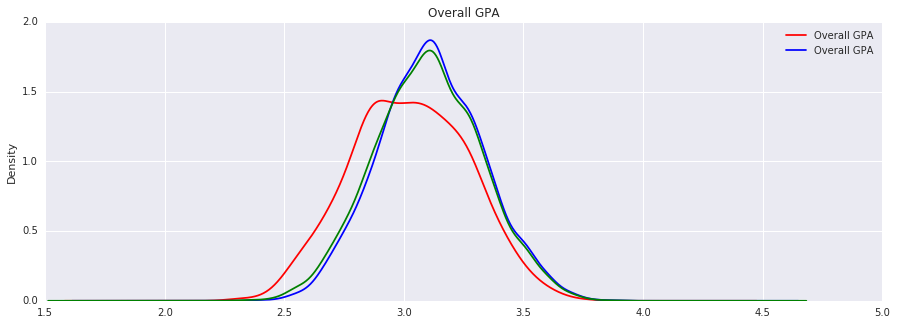

In [32]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,5))
df_GPA_Not_Retained.plot(kind='density', legend=True, title="Overall GPA", color='red')
df_GPA_Retained.plot(kind='density', legend=True, title="Overall GPA", color='Blue')
df_GPA_All.plot(kind='density', color='Green')

### Standard Deviation

The data appears to be relativly symetrical, which means that a standard deviation ("average distance from the mean") can be applied. Let's figure out how spread out the data is. While there are packages to calculate standard deviation, the functions are defined below to understand what's happening.

Remember the formula for standard deviation:

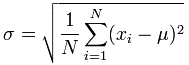

In [15]:
#Function Definitions to define standard deviation

import math

def mean(x):
    return sum(x) / len(x)

def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)""" 
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n""" 
    return dot(v, v)

def variance(x):
    """assumes x has at least two elements""" 
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x): 
    return math.sqrt(variance(x))

In [16]:
print "Standard Deviation of Students not retained: "
print standard_deviation(df_GPA_Not_Retained)

print "\nStandard Deviation of Students retained: "
print standard_deviation(df_GPA_Retained)

Standard Deviation of Students not retained: 
0.243564917133

Standard Deviation of Students retained: 
0.218624363091


### Data Analysis: Z-Score

Let's make sure the GPA data falls into the Emperical Rule, 68% of the data is within one Z-Score (One stardard deviation from the mean) and 95% within 2 Z-Score.

In [17]:
# Define a function to determine where the data falls within a zScore.

def zScoreEmpericalRule(data):
    from scipy import stats
    #68% of the data is within one Z-Score (One stardard deviation from the mean) and 95% within 2 Z-Score.
    
    #Returns an array of Z-Scores
    zScore_Not_Retained = stats.zscore(data)
    
    dataCount = data.count()
    
    zScore1Count = 0
    zScore2Count = 0
    zScoreRestCount = 0
   
    for i in zScore_Not_Retained:
        if (i >= -1.0) and (i <= 1.0):
            zScore1Count = zScore1Count + 1
        if (i <= -2.0) and (i >= 2.0):
            zScoreRestCount = zScoreRestCount + 1
    
    zScore2Count = dataCount - zScore1Count - zScoreRestCount
    
    PercentOfCurve = {'withinOne' : float(zScore1Count)/float(dataCount), 'withinTwo': (float(zScore2Count) + float(zScore1Count))/float(dataCount), 'Outside' : float(zScoreRestCount)/float(dataCount), 'Total' : dataCount}
    
    return PercentOfCurve

Below, we see that the data is almost perfectly symetric "mound" shape for both. This means that the data is distributed equally for both.

In [18]:
print "Not Retained Z-Score: "
print zScoreEmpericalRule(df_GPA_Not_Retained)

print "\nRetained Z-Score: "
print zScoreEmpericalRule(df_GPA_Retained)

Not Retained Z-Score: 
{'Outside': 0.0, 'Total': 991, 'withinTwo': 1.0, 'withinOne': 0.6579212916246215}

Retained Z-Score: 
{'Outside': 0.0, 'Total': 5212, 'withinTwo': 1.0, 'withinOne': 0.6801611665387567}


#### Conclusion :

There doesn't seem to be a large difference in Range or Centeral Value with Retained vs Not Retained students. We will need to come up with different theories/methods to what causes retention, but at least we know that GPA wasn't a large factor now!

### 4. Bernoulli Distribution

Since the the target is binary, i.e. 0 = not retained and 1 = retained, let's check out the sample distributions to see if it has normalized conditions. i.e. What is the optimal sample size to satifiy the centeral limit theorm? 

This part would be to test if you had/knew the population data size. In our case, we were only provided a sample. In other words, this is for example.

In [28]:
def sampleProportion(numberOfSamples_n, probability_p):
    #Rule of Thumb : n*p (Rule is it's greater than 10 in a normal distribution)
    # And n(1-p) >= 10
    
    if numberOfSamples_n * probability_p <= 10:
        return False
    if numberOfSamples_n * (1-probability_p) <= 10:
        return False
    else:
        return True

def samplingProportionMean(probabilitiy_p):
    #Sampling Distribution Mean is just the Sampling proportion
    return probabilitiy_p

def samplingProportionDeviation(numberOfSamples_n, probability_p):
    #Squareroot(p(1-p)/n)
    return math.sqrt((float(probability_p)*((float(1.0)-float(probability_p))/float(numberOfSamples_n))))

def getSampleSize(probability_p):
    count = 0
    while (sampleProportion(count, retainedPercent) != True ):
       #print 'The count is:', count
       count = count + 1

    return count

def testAproxIndependent(sampleCount, totalCount):
    #Is the data approximatly independent? (Even if dependent, if sample is less than 10% of data, it is apox independent)
    if (float(sampleCount/totalCount) > .10):
        return False
    else:
        return True
        

In [29]:
# Experiment with the sample size to see what a normal distribution would be.
sampleSize = 63

retainedCount = float(df_GPA_Retained.count())
notRetainedCount = float(df_GPA_Not_Retained.count())
total = retainedCount + notRetainedCount


print "Retained Count (1): "  
print retainedCount

print "\nNot Retained Count (0): "
print notRetainedCount

print "\nTotal (n): "
print total

print "\nIs the data aproximatly independent based on sample size ", sampleSize, "?(Even if Dependent)"
print testAproxIndependent(sampleSize, total)

retainedPercent =  float(retainedCount/total)
notRetainedPercent = float(notRetainedCount/total)

print "\nIs the Sample size", sampleSize, "a normal sample distribution?"
print sampleProportion(sampleSize, retainedPercent)

print "\nSample Proportion Mean using sample size:" , sampleSize
print samplingProportionMean(retainedPercent)

print "\nSample Proportion Deviation using sample size:",  sampleSize
print samplingProportionDeviation(sampleSize, retainedPercent)
 

#TODO: FIND CDF?

Retained Count (1): 
5212.0

Not Retained Count (0): 
991.0

Total (n): 
6203.0

Is the data aproximatly independent based on sample size  63 ?(Even if Dependent)
True

Is the Sample size 63 a normal sample distribution?
True

Sample Proportion Mean using sample size: 63
0.840238594229

Sample Proportion Deviation using sample size: 63
0.0461601248584


### Confidence Intervals and Margin of Error

Conditions for valid confidence interval:

Your data must:

1. Be a random sample
2. Fall under a Normal Condition : >= 10 Success and Failure
3. Fall under an Independence Condition :  Number of Samples (n) < 10%


In [30]:
def getStandardErrorForSample(sampleProportion, sampleSize):
    
    pHat = float(sampleProportion)
    n = sampleSize
    
    return math.sqrt((float(pHat)*((float(1.0)-float(pHat))/float(n))))

def getConfidenceIntervalHigh(sampleProportion, sampleSize,  numberOfDeviations):

    interval = getStandardErrorForSample(sampleProportion, sampleSize)
    
    return sampleProportion + interval * numberOfDeviations

def getConfidenceIntervalLow(sampleProportion, sampleSize, numberOfDeviations):

    interval = getStandardErrorForSample(sampleProportion, sampleSize)
    
    return sampleProportion - interval * numberOfDeviations

def displayConfidenceInterval(sampleProportion, sampleSize):
    
    SE = getStandardErrorForSample(meanOfTheSampleDistribution, sampleSize)
    
    print "Standard Error (S/E) for Sample: ", SE
    
    ciLow = getConfidenceIntervalLow(meanOfTheSampleDistribution, sampleSize, 2)
    ciHigh = getConfidenceIntervalHigh(meanOfTheSampleDistribution, sampleSize, 2)
    
    print "Margin of Error: ", getStandardErrorForSample(meanOfTheSampleDistribution, sampleSize) * 2
    
    print "Confidence Interval - There is a 95% chance that between ", ciLow * 100 , "-", ciHigh * 100, "%  will happen (not be retained in this example)"

In [31]:
sampleSize = total
meanOfTheSampleDistribution = notRetainedCount / (sampleSize)

displayConfidenceInterval(meanOfTheSampleDistribution, sampleSize)


Standard Error (S/E) for Sample:  0.00465196414789
Margin of Error:  0.00930392829578
Confidence Interval - There is a 95% chance that between  15.0457477476 - 16.9065334067 %  will happen (not be retained in this example)


In [33]:
df_data_1_sample.head(2)

,Gender,College,In or Out of State,Citizenship,Marital Status,Type of High School,Applied Financial Aid,Received Financial Aid,Other Scholarships,Tuition Rate,...,Total Class Hours,Overall GPA,Change in GPA,Housing,Club Memberships,Infirmary Visits,City,State,Retention,counts
0,Female,Liberal Arts & Sciences,Out of State,Yes,Single,Private,Yes,Yes,No,1975,...,26,3.615000,Negative,On Campus,2,0,"Huntsville, AL",Alabama,Retained,1
1,Male,Health Sciences,Out of State,Yes,Single,Public,Yes,No,No,1975,...,31,2.807742,Positive,On Campus,3,0,"Birmingham, AL",Alabama,Retained,1


In [56]:
gender = df_data_1_sample.groupby(['Gender','Retention']).count()['counts']
gender = gender.reset_index()
gender

,Gender,Retention,counts
0,Female,Not retained,509
1,Female,Retained,2719
2,Male,Not retained,482
3,Male,Retained,2493


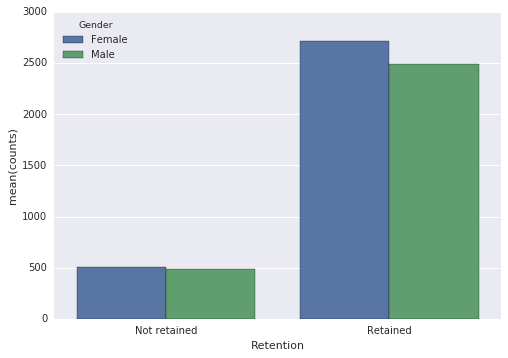

In [58]:
gender = df_data_1_sample.groupby(['Gender','Retention']).count()['counts']
gender = gender.reset_index()
sns.barplot(x='Retention',y='counts',hue='Gender',data=gender)

In [77]:
#Break up the counts

#0 - Not Retained
#1 - Retained

Female_0 = float(gender['counts'][0])
Female_1 = float(gender['counts'][1])
Male_0 = float(gender['counts'][2])
Male_1 = float(gender['counts'][3])

In [155]:
def comparePopulationProportions(zeroCountGroup1, oneCountGroup1, zeroCountGroup2, oneCountGroup2):
    
    significanceLevel = 1.96 #5% significance level, look at z table
    
    totalGroup1 = oneCountGroup1 + zeroCountGroup1
    
    totalGroup2 = oneCountGroup2 + zeroCountGroup2
    
    muGroup1 = float(oneCountGroup1/zeroCountGroup1)
    muGroup2 = float(oneCountGroup2/zeroCountGroup2)
    
    deviationGroup1 = oneCountGroup1 * (1 - oneCountGroup1) / totalGroup1
    deviationGroup2 = oneCountGroup2 * (1 - oneCountGroup2) / totalGroup2
    
    print "Mu (p1-bar) Group1: ", muGroup1 
    print "Sigma Group1: ", deviationGroup1
    
    print "Mu (p2-bar) Group2: ", muGroup2
    print "Sigma Group1: ", deviationGroup2
    
    muDiff = muGroup1 - muGroup2
    
    print "Sample distribution of p1 - p2 : ",  muDiff 
    
    deviationP1P2 = math.sqrt( ((muGroup1 * (1 - muGroup1))/totalGroup1) + ((muGroup2 * (1 - muGroup2))/totalGroup2))
    
    print "Deviation p1 - p2: ",  deviationP1P2
    
    distance = deviationP1P2 * significanceLevel 
    
    print "Confidence Interval for 95% (distance + or -) : ", distance
    
    print "95% confidence for the average (p1 - p2):", muDiff - distance ,"and", muDiff + distance 

In [156]:
gender

,Gender,Retention,counts
0,Female,Not retained,509
1,Female,Retained,2719
2,Male,Not retained,482
3,Male,Retained,2493


#### One last hypothesis

We can also see if gender has anything to do with retention with the function above. Let's do one more test.

In [157]:
comparePopulationProportions(Female_1, Female_0, Male_1, Male_0)

Mu (p1-bar) Group1:  0.187201176903
Sigma Group1:  -80.102850062
Mu (p2-bar) Group2:  0.193341355796
Sigma Group1:  -77.9300840336
Sample distribution of p1 - p2 :  -0.00614017889296
Deviation p1 - p2:  0.00997798949467
Confidence Interval for 95% (distance + or -) :  0.0195568594095
95% confidence for the average (p1 - p2): -0.0256970383025 and 0.0134166805166


### Final thoughts

The confidence for the average between the two values doesn't significantly skew (it's close to and between 0). Basically, this means that gender is also not a factor. We need something more powerful.

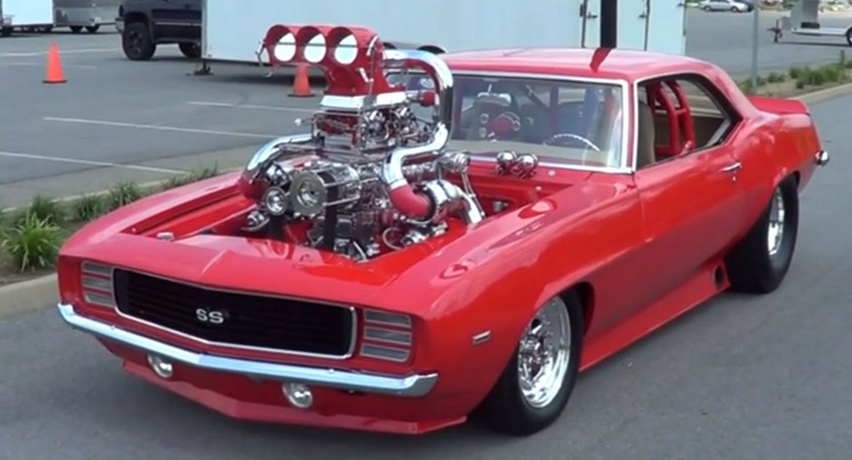